In [4]:
import numpy as np
import scipy as sc
import csv
import matplotlib.pyplot as plt

In [2]:
alpha = -0.97
beta = 1.05
rho = 0.0002

In [81]:
def F(P, E): # double well potential
    return (alpha*P**2)/2 + (beta*P**4)/4 + beta*P*E

def solFP(P,E): #dU/DP
    return alpha*P + beta*P**3 + beta*E

def findPAPC(E): #finding the equi points
    PA = sc.optimize.fsolve(solFP,2,args=(E))
    PB = sc.optimize.fsolve(solFP,-2,args=(E))
    PC = sc.optimize.fsolve(solFP,0,args=(E))
    return np.array([PA, PB, PC])

def findrk(Vpluse, D): #finding the double well hight
    E = Vpluse
    [PA,PB,PC] = findPAPC(E)
    F2derPA = alpha + 3*beta*PA**2
    F2derPC = alpha + 3*beta*PC**2
    deltaF = abs(F(PC,E) - F(PA,E))
    #kramers time
    rk = (abs(F2derPA*F2derPC))**0.5/(2*np.pi*rho)*np.exp(-deltaF/D)
    return rk

def fit_a_b(V, a, b):
    return -(a*V + b*V**3)

def finddU(Vpluse): #finding double well depth
    E = Vpluse
    PA,PB,PC = findPAPC(E)
    return abs(F(PC,E) - F(PA,E))

def TDGL(t, P, E, alpha, beta, rho):
    P_fit = [P[0]]
    dt = t[1] - t[0]
    for i in range(1,len(t)):
        df_dp = alpha*P_fit[i-1] + beta*P_fit[i-1]**3 + beta*E[i]
        P_fit.append(P_fit[i-1] - dt/rho*df_dp)
    return np.array(P_fit)*1

def sin_wave(M, frequency, dt):
    T = 1 / frequency  # Period of the wave
    t = np.arange(0, 4*T, dt)  # Time values
    # Generate triangular wave: 0 → +max → -max → 0
    y =  M*np.sin(2*np.pi*t*frequency)
    return t, y

In [38]:
# Dictionary to store results
data = {}

#Hyst data
# Frequencies to read
freqs = [50, 100, 150]

for f in freqs:
    Vin, Vout = [], []
    filename = f"data/hyst_{f}hz.csv"
    
    with open(filename, mode="r") as file:
        reader = csv.reader(file)
        for row in reader:
            Vin.append(float(row[0]))
            Vout.append(float(row[1]))
    
    # Store in dictionary for easy access
    data[f] = {"Vin": np.array(Vin), "Vout": np.array(Vout)}

#Ktime measurement results
Kt_100 = np.array([75804.66, 37081.47, 20765.69, 14783.99, 10114.07, 7905.03, 6380.39, 4976.49, 4125.87, 3542.3, 4235.16])
Kt_75 = np.array([121573.38, 57695.5, 30838.43, 17917.06, 13486.9, 9902.96, 7132.7, 5726.8, 4610.04, 3992.87, 4285.82])
Kt_50 =  np.array([225451.8, 92181.4, 41022.75, 24939.97, 16596.76, 11944.56, 8777.86, 7105.07, 5432.45, 4975.76, 5131.87])

#P-plot measurement
ts = [1,2,3,4,6,8,11,15,19,22,27,32,39,46,55,66,79,149,200]
P_075 = [0.0, 0.04, 0.07, 0.11, 0.15, 0.22, 0.33, 0.44, 0.53, 0.59, 0.65, 0.7, 0.75, 0.86, 0.89, 0.92, 0.96, 0.99, 0.98]
P_100 = [0.07, 0.11, 0.14, 0.24, 0.31, 0.42, 0.53, 0.64, 0.74, 0.77, 0.82, 0.89, 0.93, 0.95, 0.97, 0.99, 0.99, 0.99, 1]
P_050 = [0.01, 0.03, 0.06, 0.08, 0.12, 0.15, 0.22, 0.33, 0.37, 0.46, 0.51, 0.56, 0.67, 0.73, 0.76, 0.83, 0.88, 0.97, 0.98]

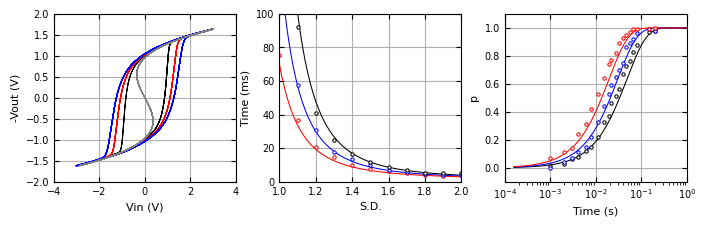

In [90]:
# Figure size (6 in wide, 2 in tall)
fig = plt.figure(figsize=(7, 2.2))

# Style parameters
clr = ["black", "red", "blue"]
cl = ["black", "blue", "red"]
lwth = 0.75          # line width
msize = 2.4          # marker size
fsize = 8           # font size
m = "o"
mwth = 0.75
# ----------------------
# Hysteresis plot
# ----------------------
plt.subplot(1, 3, 1)
for i, f in enumerate(freqs):
    plt.plot(data[f]["Vin"], -data[f]["Vout"], 
             label=f"{f} Hz", c=clr[i], linewidth=lwth)
    
plt.plot(fit_a_b(data[f]["Vout"][::10], alpha, beta), -data[f]["Vout"][::10], "--", c="gray", linewidth=lwth, label = "without damping")

plt.xlim([-4, 4])
plt.ylim([-2, 2])
plt.xlabel("Vin (V)", fontsize=fsize)
plt.ylabel("-Vout (V)", fontsize=fsize)
plt.tick_params(axis="both", direction="in", top=True, right=True, labelsize=fsize-1)
plt.grid(True)

# ----------------------
# Ktime plot
# ----------------------
plt.subplot(1, 3, 2)
sd = np.linspace(1, 2, 100)
sdm = np.linspace(1, 2, 11)
BW = 80e3
E = [0.05, 0.075, 0.1]
D = (sd**2) / (2 * rho * BW)

for i, Es in enumerate(E):
    plt.plot(sd, (1/findrk(Es, D))*1e3, "-", c=cl[i], linewidth=lwth)

plt.plot(sdm, Kt_100/1e3, m, c=cl[2], ms=msize, mew = mwth, markerfacecolor='white', label="meas 0.1 V")
plt.plot(sdm, Kt_75/1e3, m, c=cl[1], ms=msize, mew = mwth, markerfacecolor='white', label="meas 0.075 V")
plt.plot(sdm, Kt_50/1e3, m, c=cl[0], ms=msize, mew = mwth, markerfacecolor='white', label="meas 0.05 V")

plt.xlim([1, 2])
plt.ylim([0, 100])
plt.xlabel("S.D.", fontsize=fsize)
plt.ylabel("Time (ms)", fontsize=fsize)
plt.tick_params(axis="both", labelsize=fsize-1)
plt.tick_params(axis="both", direction="in", top=True, right=True, labelsize=fsize-1)
plt.grid(True)

# ----------------------
# P plot
# ----------------------
plt.subplot(1, 3, 3)
tp1 = np.logspace(-3.8, -3, 50)
tp2 = np.logspace(-3, -1.8, 100)
tp3 = np.logspace(-1.8, -1.1, 100)
tp4 = np.logspace(-1.1, 0, 50)
tp = np.concatenate((tp1, tp2, tp3, tp4))

sd = 1.2
D = (sd**2) / (2 * rho * BW)

for i, Es in enumerate(E):
    plt.semilogx(tp, 1 - np.exp(-tp*findrk(Es, D)), "-", c=cl[i], linewidth=lwth)

plt.semilogx(np.array(ts)*1e-3, P_050, m, c=cl[0], ms=msize, mew = mwth, markerfacecolor='white', label="meas V = 0.05 V")
plt.semilogx(np.array(ts)*1e-3, P_075, m, c=cl[1], ms=msize, mew = mwth, markerfacecolor='white', label="meas V = 0.075 V")
plt.semilogx(np.array(ts)*1e-3, P_100, m, c=cl[2], ms=msize, mew = mwth, markerfacecolor='white', label="meas V = 0.1 V")

plt.xlabel("Time (s)", fontsize=fsize)
plt.ylabel("p", fontsize=fsize)
plt.xlim([1e-4, 1])
plt.ylim([-0.1, 1.1])
plt.tick_params(axis="both", labelsize=fsize-1)
plt.tick_params(axis="both", direction="in", top=True, right=True, labelsize=fsize-1)
plt.grid(True)

# ----------------------
# Adjust layout
# ----------------------
plt.tight_layout(pad=0.5, w_pad=0, h_pad=0)
plt.savefig("raw_fig/surrogate_meas.pdf", dpi=300, bbox_inches="tight")
plt.show()


In [99]:
data_Pset = np.load("data/Pset_meas1_10.5.24.npz")
data_P05 =  np.load("data/P05_meas_10.5.24.npz")

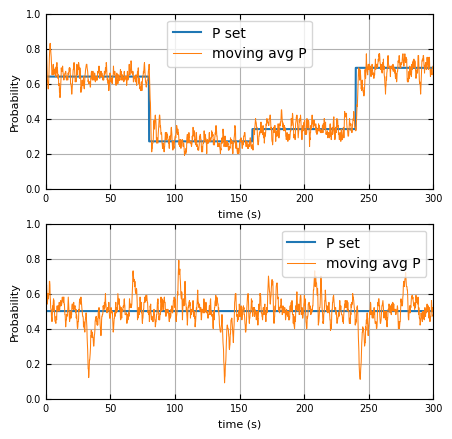

In [116]:
f = 50 #Hz
n = 10
P_meas1, P_set1, V_bias1 = data_Pset['arr_0'], data_Pset['arr_1'], data_Pset['arr_2']
P_meas2, P_set2, V_bias2 = data_P05['arr_0'], data_P05['arr_1'], data_P05['arr_2']


t1 = np.arange(0, len(P_set1)*n/f, n/f)
t2 = np.arange(0, len(P_set2)*n/f, n/f)

plt.figure(figsize=(5, 5))
plt.subplot(2,1,1)
to = 400*2
fro = 400*7
plt.plot(t1[to:fro]-t1[to], P_set1[to:fro], label = "P set",  linewidth=lwth*2)
plt.plot(t1[to:fro]-t1[to], P_meas1[to:fro], label = "moving avg P",  linewidth=lwth)
plt.xlabel("time (s)", fontsize=fsize)
plt.ylabel("Probability", fontsize=fsize)
plt.tick_params(axis="both", labelsize=fsize-1)
plt.tick_params(axis="both", direction="in", top=True, right=True, labelsize=fsize-1)
# plt.title("P controller (Kp = 0.2, Ki = 0.08, f = 50hz, mv_avg window = 100)")
plt.legend()
plt.ylim([0,1])
plt.xlim([0,300])
plt.grid()

plt.subplot(2,1,2)
to = 0
fro = -1
plt.plot(t2[to:fro], P_set2[to:fro], label = "P set",  linewidth=lwth*2)
plt.plot(t2[to:fro], P_meas2[to:fro], label = "moving avg P",  linewidth=lwth)
plt.xlabel("time (s)", fontsize=fsize)
plt.ylabel("Probability", fontsize=fsize)
plt.tick_params(axis="both", labelsize=fsize-1)
plt.tick_params(axis="both", direction="in", top=True, right=True, labelsize=fsize-1)
# plt.title("P controller (Kp = 0.2, Ki = 0.08, f = 50hz, mv_avg window = 100)")
plt.legend()
plt.ylim([0,1])
plt.xlim([0,300])
plt.grid()

# plt.savefig("Pset_meas.pdf")

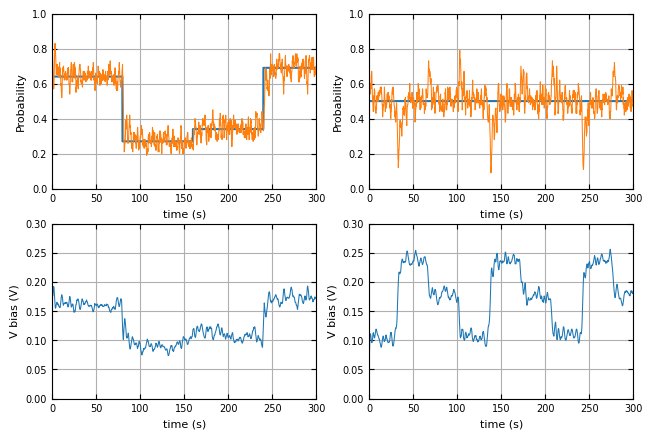

In [128]:
def moving_average(x, w=50):
    return np.convolve(x, np.ones(w)/w, mode='same')

f = 50 #Hz
n = 10
P_meas1, P_set1, V_bias1 = data_Pset['arr_0'], data_Pset['arr_1'], data_Pset['arr_2']
P_meas2, P_set2, V_bias2 = data_P05['arr_0'], data_P05['arr_1'], data_P05['arr_2']

# Apply filter
V_bias1_filt = moving_average(V_bias1, w=10)  # adjust w to smooth more/less
V_bias2_filt = moving_average(V_bias2, w=10)

t1 = np.arange(0, len(P_set1)*n/f, n/f)
t2 = np.arange(0, len(P_set2)*n/f, n/f)

plt.figure(figsize=(7.5, 5))
plt.subplot(2,2,1)
to = 400*2
fro = 400*7
plt.plot(t1[to:fro]-t1[to], P_set1[to:fro], label = "P set",  linewidth=lwth*2)
plt.plot(t1[to:fro]-t1[to], P_meas1[to:fro], label = "moving avg P",  linewidth=lwth)
plt.xlabel("time (s)", fontsize=fsize)
plt.ylabel("Probability", fontsize=fsize)
plt.tick_params(axis="both", labelsize=fsize-1)
plt.tick_params(axis="both", direction="in", top=True, right=True, labelsize=fsize-1)
# plt.title("P controller (Kp = 0.2, Ki = 0.08, f = 50hz, mv_avg window = 100)")
# plt.legend()
plt.ylim([0,1])
plt.xlim([0,300])
plt.grid()

plt.subplot(2,2,3)
to = 400*2
fro = 400*7
plt.plot(t1[to:fro]-t1[to], V_bias1_filt[to:fro], label = "P set",  linewidth=lwth)
plt.xlabel("time (s)", fontsize=fsize)
plt.ylabel("V bias (V)", fontsize=fsize)
plt.tick_params(axis="both", labelsize=fsize-1)
plt.tick_params(axis="both", direction="in", top=True, right=True, labelsize=fsize-1)
# plt.title("P controller (Kp = 0.2, Ki = 0.08, f = 50hz, mv_avg window = 100)")
# plt.legend()
plt.ylim([0,0.3])
plt.xlim([0,300])
plt.grid()

plt.subplot(2,2,2)
to = 0
fro = -1
plt.plot(t2[to:fro], P_set2[to:fro], label = "P set",  linewidth=lwth*2)
plt.plot(t2[to:fro], P_meas2[to:fro], label = "moving avg P",  linewidth=lwth)
plt.xlabel("time (s)", fontsize=fsize)
plt.ylabel("Probability", fontsize=fsize)
plt.tick_params(axis="both", labelsize=fsize-1)
plt.tick_params(axis="both", direction="in", top=True, right=True, labelsize=fsize-1)
# plt.title("P controller (Kp = 0.2, Ki = 0.08, f = 50hz, mv_avg window = 100)")
# plt.legend()
plt.ylim([0,1])
plt.xlim([0,300])
plt.grid()

plt.subplot(2,2,4)
to = 0
fro = -1
plt.plot(t2[to:fro], V_bias2_filt[to:fro], label = "P set",  linewidth=lwth)
plt.xlabel("time (s)", fontsize=fsize)
plt.ylabel("V bias (V)", fontsize=fsize)
plt.tick_params(axis="both", labelsize=fsize-1)
plt.tick_params(axis="both", direction="in", top=True, right=True, labelsize=fsize-1)
plt.ylim([0,0.3])
plt.xlim([0,300])
plt.grid()

plt.savefig("raw_fig/Controller_fig.pdf")

delU at 0.1 =  [0.13184578]
delU at 0.075 =  [0.15321376]
delU at 0.05 =  [0.17571804]


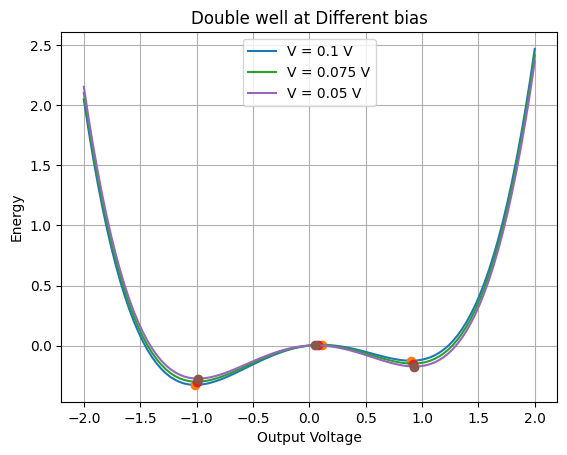

In [5]:
P = np.linspace(-2,2,100)
E = [0.1, 0.075, 0.05]
for Es in E:
    plt.plot(P,F(P,Es), label = f"V = {Es} V")
    plt.plot(findPAPC(Es), F(findPAPC(Es), Es), "o")
    print(f"delU at {Es} = ", finddU(Es))
plt.xlabel("Output Voltage")
plt.ylabel("Energy")
plt.title("Double well at Different bias")
plt.legend()
plt.grid()